In [237]:
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)

files = glob.glob('./server_results/grid_search/*.csv')


In [ ]:
def best_aggregate(df):
    
    df_grouped = df.groupby(['encoding_mode', 'sampling_mode', 'sampling_size'])['mrr'].agg(['mean','median','min', 'max','std']).reset_index()
    
    df_grouped = df_grouped.sort_values(by='mean', ascending=False)

    

    print(df_grouped.head(10).to_string())
    return df_grouped

def most_high_mrr(df):
    df['method_strategy'] = df['encoding_mode'] + '_' + df['sampling_mode'] + '_' + df['sampling_size'].astype(str)
    highest_mrr_counts = df.groupby('method_strategy')['mrr'].apply(lambda x: (x == x.max()).sum()).reset_index(name='count')
    print(highest_mrr_counts.head(10).to_string())
    return df




def plot_grouped_bar(df, x, hue, group, y, datasetname):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))

    # df = df[df['sampling_mode'] == 'mixed']

    if group == 'sampling_size':
        df = df[df['sampling_size'] == 10]

    order = df.groupby(x)[y].mean().sort_values(ascending=False).index
    
    # Plot the boxplot
    sns.boxplot(
        data=df,
        x=x,
        hue=hue,
        y=y,
        ax=ax,
        palette=sns.color_palette("Set2"),  # Use a better palette
        order=order
    )
    
    # Set labels and title
    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    ax.set_title(f'{y} Distribution for {x} and {hue} in {datasetname}', fontsize=14)
    
    # Customize ticks
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Place legend at the bottom, without border
    ax.legend(
        title=hue, 
        fontsize=12, 
        title_fontsize=12, 
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.05),  # Position legend outside plot
        ncol=3,  # Arrange legend in a single row
        frameon=False  # Remove legend border
    )
    
    # Adjust layout to ensure everything fits
    plt.tight_layout()
    plt.show()

def plot_grouped_bar_grouped(df, x, hue, group, y, datasetname):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Combine hue and group into a single categorical column for better grouping
    df['combined_hue'] = df[hue].astype(str) + " | " + df[group].astype(str)
    
    # Plot the boxplot
    sns.boxplot(
        data=df,
        x=x,
        hue='combined_hue',  # Use the combined hue
        y=y,
        ax=ax,
        palette=sns.color_palette("Set2"),  # Use a better palette
    )
    
    # Set labels and title
    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    ax.set_title(f'{y} Distribution for {x}, {hue}, and {group} in {datasetname}', fontsize=14)
    
    # Customize ticks
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Place legend at the bottom, without border
    ax.legend(
        title=f'{hue} | {group}', 
        fontsize=12, 
        title_fontsize=12, 
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.05),  # Position legend outside plot
        ncol=3,  # Arrange legend in a single row
        frameon=False  # Remove legend border
    )
    
    # Adjust layout to ensure everything fits
    plt.tight_layout()
    plt.show()







In [239]:
print('Aggregates')
for file in files:
    datasetname = file.split('_')[0]
    datasetname = file.split('/')[-1].split('_')[0]    
    print(f'Analyzing {datasetname}')
    df = pd.read_csv(file)
    df_grouped = best_aggregate(df)
    

Aggregates
Analyzing ChEMBL
            encoding_mode sampling_mode  sampling_size      mean    median       min  max       std
16  header_values_default         mixed             10  0.919512  0.954545  0.571429  1.0  0.096994
40   header_values_repeat         mixed             10  0.908449  0.938447  0.604805  1.0  0.104106
64  header_values_verbose         mixed             10  0.908235  0.937500  0.500000  1.0  0.102804
52   header_values_simple         mixed             10  0.904446  0.937500  0.513336  1.0  0.102867
55   header_values_simple         mixed             30  0.899598  0.916667  0.500000  1.0  0.110971
45   header_values_repeat        random             15  0.893645  0.917929  0.500000  1.0  0.114800
46   header_values_repeat        random             20  0.890102  0.916667  0.500000  1.0  0.119604
65  header_values_verbose         mixed             15  0.888477  0.916667  0.500000  1.0  0.119497
20  header_values_default        random             10  0.887806  0.9166

Frequency
Analyzing ChEMBL


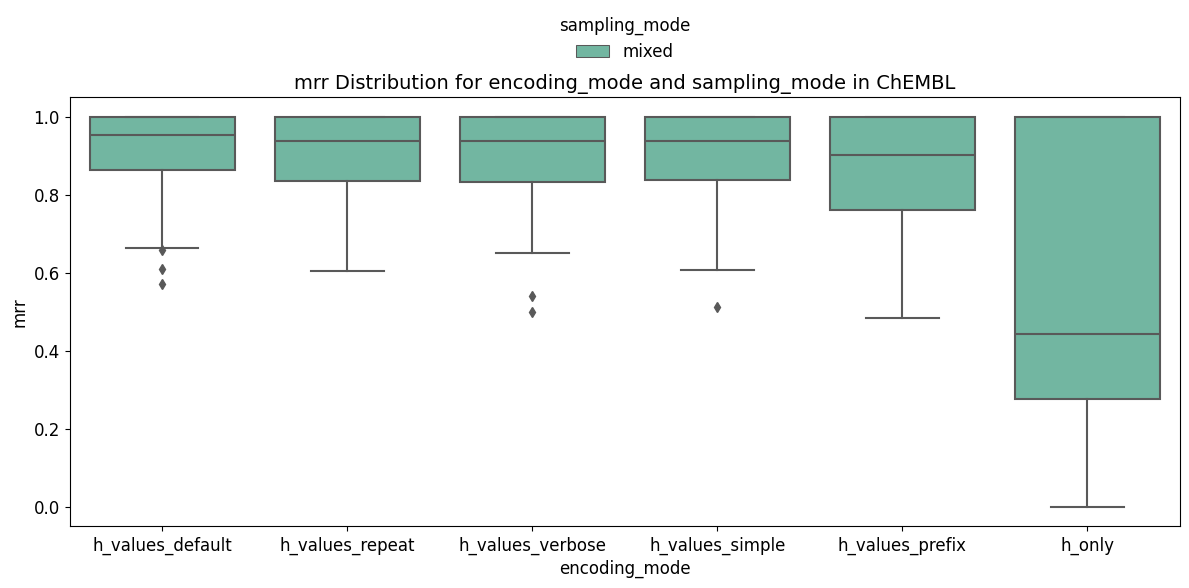

Analyzing OpenData


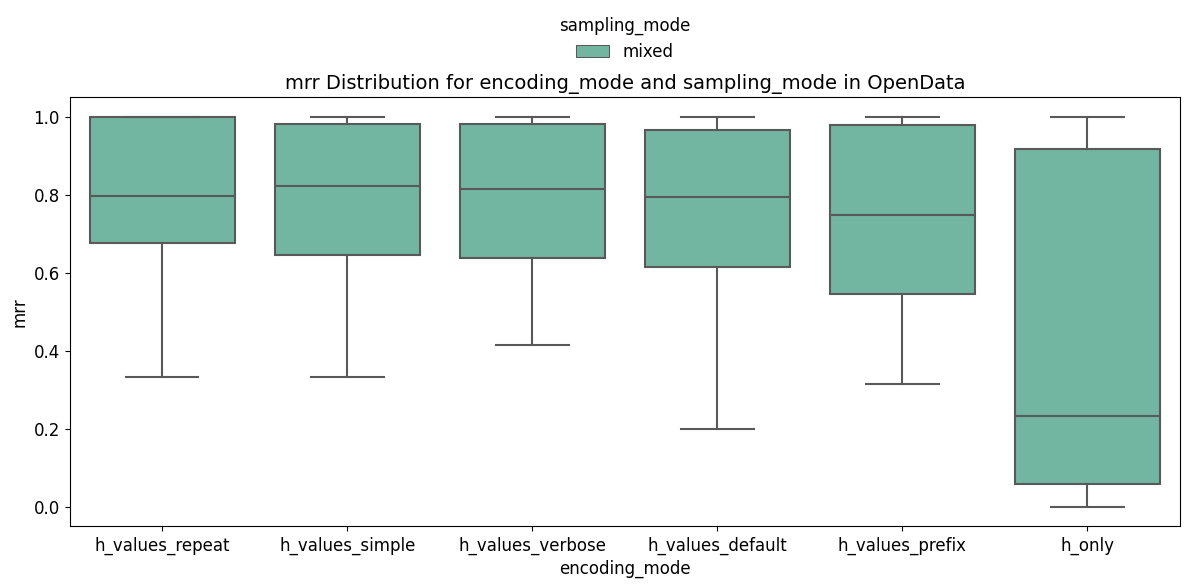

Analyzing GDC


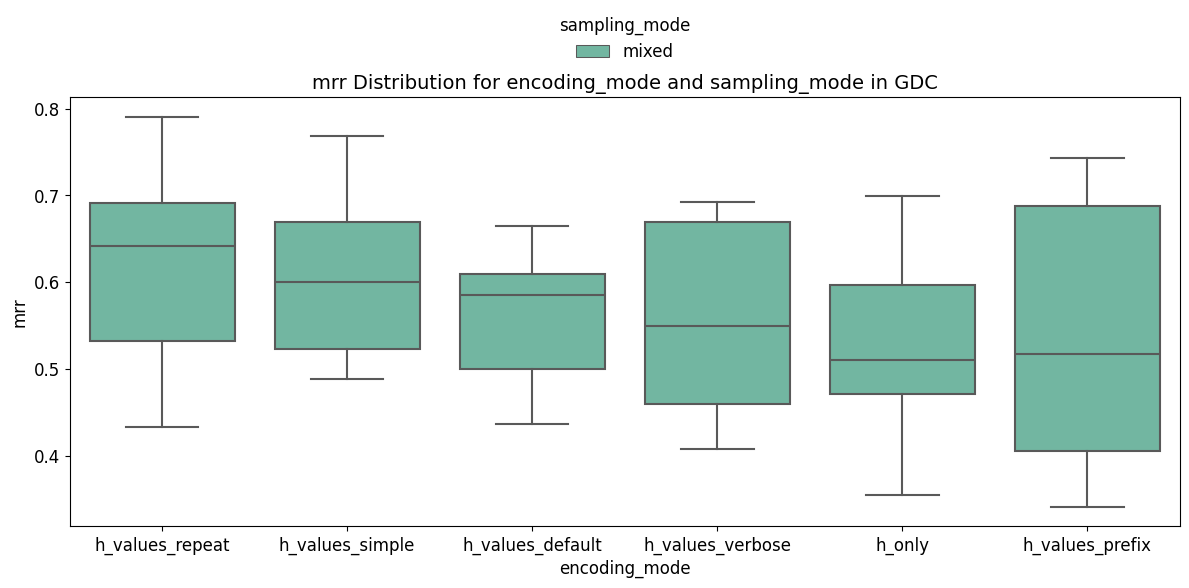

Analyzing Magellan


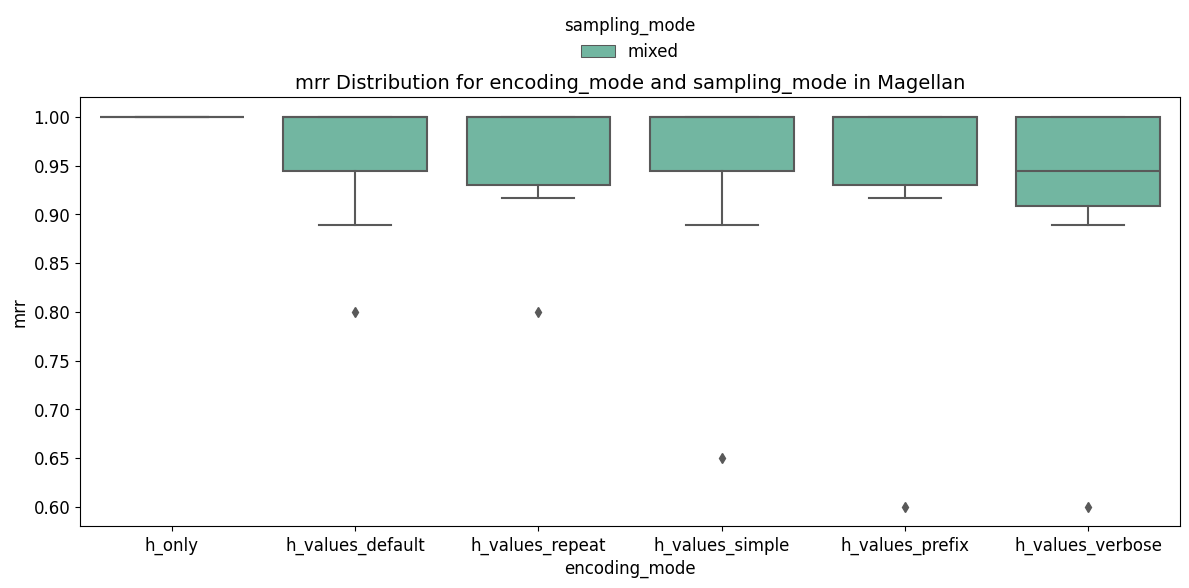

Analyzing Musicians


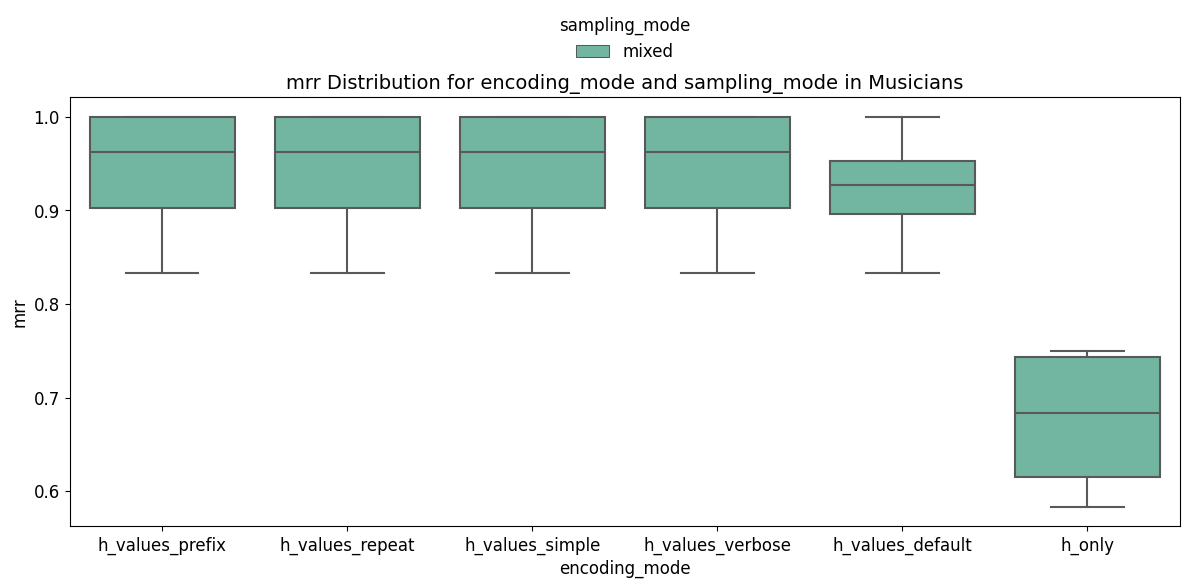

Analyzing TPC-DI


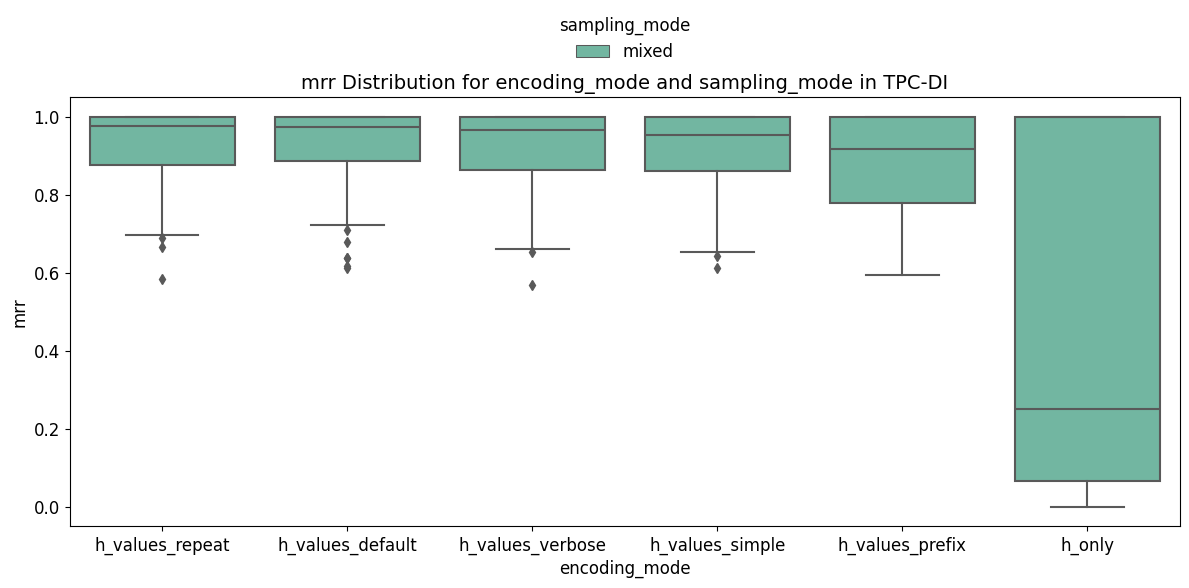

In [240]:





print('Frequency')
all_dfs=[]
for file in files:
    datasetname = file.split('_')[0]
    datasetname = file.split('/')[-1].split('_')[0]    
    print(f'Analyzing {datasetname}')
    df = pd.read_csv(file)

    df['encoding_mode'] = df['encoding_mode'].str.replace('header_', 'h_')

    all_dfs.append(df)

    



    #plot_grouped_bar(df, 'encoding_mode', 'sampling_mode', 'sampling_size', 'mrr',datasetname)
    plot_grouped_bar(df, 'encoding_mode', 'sampling_mode', 'sampling_size', 'mrr',datasetname)
    

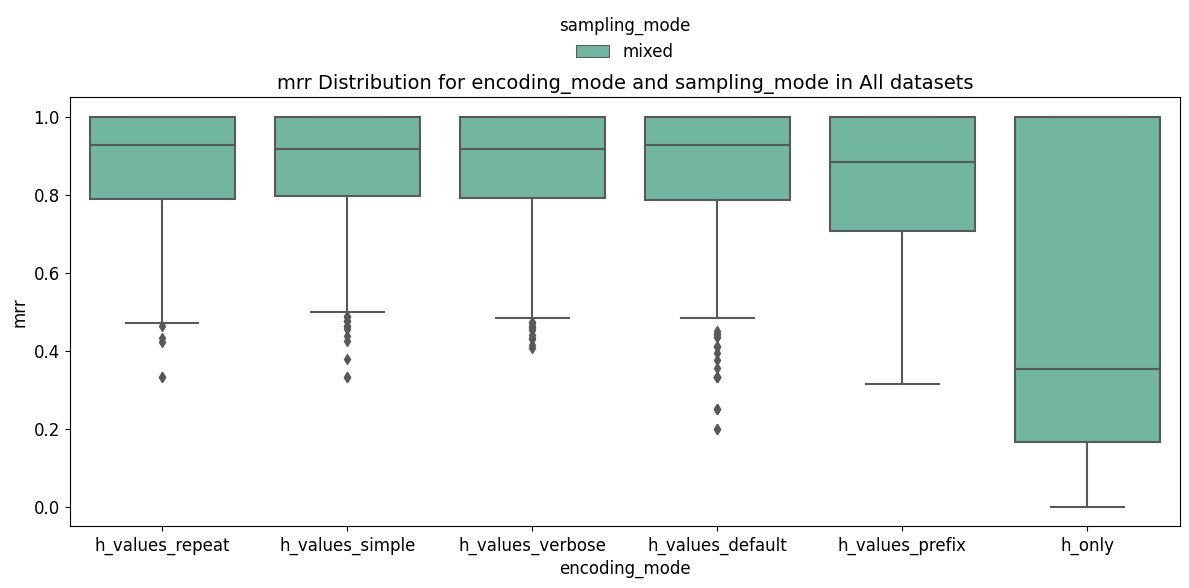

In [241]:
df = pd.concat(all_dfs)
plot_grouped_bar(df, 'encoding_mode', 'sampling_mode', 'sampling_size', 'mrr','All datasets')